In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import math
from OpfModel import add_opf_constraints
from ThermalModel import add_indoor_constraints
from HHPmodel import add_hhp_constraints

In [2]:
#tem input
TemInd_file_path = "data/TemperaturesInd.csv"
def TemInd_input(Tem_file_path):
    #indoor tem in time 0
    Indtem_data_row = pd.read_csv(Tem_file_path)
    Indtem_data_row['time'] = pd.to_datetime(Indtem_data_row['time'])
    #degree to value
    Indtem_data_row["Room 1 - Actual"] = Indtem_data_row["Room 1 - Actual"].str.replace(" °C", "").astype(float)
    Indtem_data_row["Room 1 - Set"] = Indtem_data_row["Room 1 - Set"].str.replace(" °C", "").astype(float)
    
    # create a new list with every 15 min in a day
    TimeStep = pd.date_range(start='2/1/2024', end='2/2/2024', freq='15min')
    TimeStep = TimeStep[:-1]
    TimeStep = pd.DataFrame(TimeStep, columns=["time"])
    #find the nearest time in the Room 1 - Actual, some data in Room 1 - Actual do not have the absolute 15 min data, need to find the nearest time
    Indtem_data_row = pd.merge_asof(TimeStep, Indtem_data_row, on="time")


    # Indtem_data_row["time_15min"] = Indtem_data_row["time"].dt.floor("15min")
    # averages = Indtem_data_row.groupby("time_15min")[["Room 1 - Actual", "Room 1 - Set"]].mean().reset_index()
    
    Tem_ind= Indtem_data_row ["Room 1 - Actual"].values
    return Tem_ind

TemOut_file_path = "data/TemperaturesOut.csv"
def TemOut_input(Tem_file_path):
    # outdoor tem set
    Outtem_data_row = pd.read_csv(Tem_file_path)
    # Outtem_data_row
    Outtem_data_row['time'] = pd.to_datetime(Outtem_data_row['time'])
    #degree to value
    Outtem_data_row["Outside"] = Outtem_data_row["Outside"].str.replace(" °C", "").astype(float)
    #average 15min
    Outtem_data_row["time_15min"] = Outtem_data_row["time"].dt.floor("15min")
    tem_amb = Outtem_data_row.groupby("time_15min")[["Outside"]].mean().reset_index()
    T_amb=tem_amb["Outside"].values
    return T_amb

Tem_ind = TemInd_input(TemInd_file_path)
T_amb = TemOut_input(TemOut_file_path)


In [3]:
#units in kA, kV, MW, MVA,MVar,Euro,m^3

Time_day=96

s_trafo = 0.23*0.16*3 #data from DACS area7

#network
network=pd.read_csv("data\\network.csv")
connect1=pd.read_excel("data\\user_connect.xlsx")
user_index=connect1["Node"].tolist()
n_bus=len(network)+1
n_user= len(user_index)  #in DACS7, last one's load is 0 

#pv
pv_cap=connect1["PV"]*1E-3 #pv capacity from dacs data
pv_cap=pv_cap.tolist()

#hp
hp_own=connect1["HP"].tolist()
pf = 0.9 # baseload & HP
tan_phi_load = (np.sqrt(1-pf**2))/pf
p_hp_max=5*1e-3  #5kw
p_hp_min =3*1e-3 #1.8kw
p_boil_max=15*1e-3 #15kw
p_boil_min=1*1e-3 #1kw

#indoor thermal parameter
C_house=(10+0.2+30)
R_house=1/(1/7+1/6+1/2)
COP=4.5
x_vals = list(range(19, 24))  # T_ind values from 15 to 25
y_vals = [12.3, 9.9, 8.2, 7.2, 6.6]  # PPD values
Pn = len(x_vals)
#cost set
c_loss = 40
c_grid = 500
c_hp_down = 400
c_pv = 400

price_data = pd.read_csv("data\\price_data.csv")
filtered_data = price_data[(price_data['year'] == 2024) & (price_data['month'] == 2) & (price_data['day'] == 1)]
ele_price=filtered_data['energy_price_full'].values
gas_price=filtered_data['gas_price_full'].values

gas_LHV = 10.16  # kWh/m3



#pv constrain
pf_pv_limit = 0.95
tan_phi_pv = (np.sqrt(1-pf_pv_limit**2))/pf_pv_limit


#voltage constrain
v_ref = 0.23 # kV
v_lb = 0.96 #pu
v_ub = 1.04
#power

df=pd.read_csv("data\\UserPower.csv",index_col=0)
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y %I:%M %p')
# Filter for rows where the date is February 1, 2024
filtered_df = df[df['time'].dt.date == pd.to_datetime("2024-02-01").date()]
LoadPower=filtered_df.copy()
LoadPower= LoadPower.reset_index(drop=True)
LoadPower.index += 1
#reactive power
df=pd.read_csv("data\\UserReactivePower.csv",index_col=0)
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y %I:%M %p')
filtered_df = df[df['time'].dt.date == pd.to_datetime("2024-02-01").date()]
LoadReact=filtered_df.copy()
LoadReact= LoadReact.reset_index(drop=True)
LoadReact.index += 1

#pv efficiency data in "2024-02-01"

hourly_data = [
    0, 0, 0, 0, 0, 0, 0, 0, 0.006, 0.053, 0.129, 0.179,
    0.166, 0.14, 0.094, 0.046, 0.007, 0, 0, 0, 0, 0, 0, 0
]

expanded_data = [value for value in hourly_data for _ in range(4)]
expanded_df = pd.DataFrame(expanded_data, columns=["Quarter_Hourly_Data"])

#congestion set
congestion_limit=np.ones(96)*(-50*1e-3)# define the limit, -50 is no limit
#for a congestion test
StartRe=40
EndRe=48
PRe=-100*1e-3
# congestion_limit[0]=PRe
for t in range(StartRe,EndRe):
    congestion_limit[t]=PRe

In [4]:
m = gp.Model("GEC")
m.Params.LogToConsole = 0
# define variables
p = m.addVars(n_bus,Time_day, lb = -float('inf'), vtype = GRB.CONTINUOUS, name = "PBusInjection")

q = m.addVars(n_bus, Time_day,lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "QBusInjection")

PLine = m.addVars(n_bus-1,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "PLine")
QLine = m.addVars(n_bus-1,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "QLine")
v = m.addVars(n_bus, Time_day,lb = (v_lb*v_ref)**2, ub = (v_ub*v_ref)**2, vtype = GRB.CONTINUOUS, name = "VoltSquare")
l = m.addVars(n_bus-1, Time_day,lb = 0, vtype = GRB.CONTINUOUS, name = "CurrentSquare")
p_pv = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "PVactivePower")
q_pv = m.addVars(n_user,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "PVreactivePower")

p_hp = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "HPactivePower")
q_hp = m.addVars(n_user,Time_day, lb = 0,  vtype = GRB.CONTINUOUS, name = "HPreactivePower")

p_pv_down = m.addVars(n_user,Time_day, lb = 0,  vtype = GRB.CONTINUOUS, name = "PVcurtailedActivePower")
b_hp =m.addVars(n_user,Time_day,  vtype = GRB.BINARY, name = "HP_Open")
p_hp_down = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "HPcurtailedActivePower")

#indoor variable
h_hp=m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "HPHeat")
g_boil = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "GasToBoiler")
h_boil = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "BoilerHeat")
b_boil =m.addVars(n_user,Time_day,  vtype = GRB.BINARY, name = "Boil_Open")

Heat = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "TotalHeat")
T_ind = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "IndoorTem")
PPD  = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "PPD")
lambdas = m.addVars(Pn, lb=0, ub=1, name="lambda")  # SOS2 variables


Set parameter Username
Set parameter LicenseID to value 2617326
Academic license - for non-commercial use only - expires 2026-02-03


In [ ]:
# define constraints

for t in range(Time_day):
        #choose the time
    run_time=t
    # pv efficiency in selected time
    pv_ef=expanded_df.at[run_time,"Quarter_Hourly_Data"]
    # load in selected time
    p_baseload=LoadPower.iloc[run_time,1:]*1E-3
    p_baseload=p_baseload.tolist()
    q_baseload=LoadReact.iloc[run_time,1:]*1E-3
    q_baseload=q_baseload.tolist()
    #add opf constraints
    add_opf_constraints(m, network, PLine, QLine, l, v, p, q, n_bus, t, congestion_limit, s_trafo, v_ref)
    #add hhps constraints
    add_hhp_constraints(m, p_hp, q_hp, h_hp, b_hp, g_boil, h_boil, b_boil, Heat, gas_LHV, COP, n_user, t, p_hp_max, p_hp_min, p_boil_max, p_boil_min, hp_own)
    #add thermal constraints
    add_indoor_constraints(m, T_ind, Tem_ind, Heat, T_amb, C_house, R_house, PPD, lambdas, x_vals, y_vals, Pn, n_user, t)
    
    # load constraints
    for i in range(n_bus):
        if i not in user_index and i != 0: # slack bus + residential loads
            m.addConstr(p[i,t] == 0,"busP=0")
            m.addConstr(q[i,t] == 0,"busQ=0")
        if i in user_index:
            m.addConstr(p[i,t] ==  p_baseload[i-(n_bus-n_user)] - p_pv[i-(n_bus-n_user),t] + p_hp[i-(n_bus-n_user),t], "LoadP")
            m.addConstr(q[i,t] ==  q_baseload[i-(n_bus-n_user)]  - q_pv[i-(n_bus-n_user),t] + q_hp[i-(n_bus-n_user),t], "LoadQ")          

    # m.addConstr( b_hp[i,t] == 0,"HHP_test")
    #constraints for pv hhp
    for i in range(n_user):        
        # m.addConstr(-p_pv[i,t] * tan_phi_pv <= q_pv[i,t],"pv_tan-")
        m.addConstr(q_pv[i,t] == p_pv[i,t] * tan_phi_pv,"pv_tan")
        m.addConstr(q_hp[i,t] == p_hp[i,t] * tan_phi_load,"hp_tan")         
        m.addConstr(p_pv[i,t] == pv_cap[i]*pv_ef,"pvMax")

    
    



In [6]:
# define objective
obj = 0\
+quicksum(1e3*ele_price[int(t/4)]*(-p[0,t])*0.25  for t in range(Time_day) )\
+ quicksum(gas_price[int(t/4)]*g_boil[i,t] for t in range(Time_day) for i in range(n_user))\
+ quicksum(0.27*PPD[i,t] for t in range(Time_day) for i in range(n_user))\
# + quicksum(l[i,t]*network.at[i,'R'] * 1e3*ele_price[int(t/4)]*0.25 for t in range(Time_day) for i in range(n_bus-1))\
# + quicksum(c_hp_down*p_hp_down[i,t]*0.25 for t in range(Time_day) for i in range(n_user))\
# + quicksum(c_pv*p_pv_down[i,t]*0.25 for t in range(Time_day) for i in range(n_user))\


# m.write("model.lp")
m.setObjective(obj, GRB.MINIMIZE)

In [7]:
m.Params.MIPGap = 0.01
m.optimize()


print(f"Optimization Runtime: {m.Runtime} seconds")
if m.status == GRB.OPTIMAL:
    print("Model solved successfully!")    
    # m.write("opf_model.sol")
else:
    print(f"Model status: {m.status}")


Optimization Runtime: 8.641999959945679 seconds
Model solved successfully!


In [15]:
m.write("fullmodel.lp")

In [179]:
# m.write("fullmodel.sol")

In [17]:
m.computeIIS()
m.write("infeasible.ilp")

In [8]:
#change the output name
dict_optimizedResults = {
    "p": [[p[i,t].X  for t in range(Time_day)]for i in range(n_bus)],
    "q": [[q[i,t].X  for t in range(Time_day)] for i in range(n_bus)], 
    "v_value": [[v[i,t].X  for t in range(Time_day)] for i in range(n_bus)],   
    "p_hp_down": [[p_hp_down[i,t].X for t in range(Time_day)]for i in range(n_user)], 
    "p_hp": [[p_hp[i,t].X for t in range(Time_day)]for i in range(n_user)],
    "p_pv_down": [[p_pv_down[i,t].X for t in range(Time_day)]for i in range(n_user)], 
    "p_pv": [[p_pv[i,t].X for t in range(Time_day)]for i in range(n_user)],
    "T_ind": [[T_ind[i,t].X for t in range(Time_day)]for i in range(n_user)],
    "g_boil": [[g_boil[i,t].X for t in range(Time_day)]for i in range(n_user)],
    "PPD": [[PPD[i,t].X for t in range(Time_day)]for i in range(n_user)]
    } 
# print(dict_optimizedResults)
Result_p = dict_optimizedResults["p"]
Result_q = dict_optimizedResults["q"]
Result_v= dict_optimizedResults["v_value"]
Result_hp_down = dict_optimizedResults["p_hp_down"]
Result_hp = dict_optimizedResults["p_hp"]
Result_pv_down = dict_optimizedResults["p_pv_down"]
Result_pv = dict_optimizedResults["p_pv"]
Result_T_ind = dict_optimizedResults["T_ind"]
Result_g_boil = dict_optimizedResults["g_boil"]
Result_PPD = dict_optimizedResults["PPD"]

In [9]:
print("total power")
print(Result_p[0])
print("Indoor Tem:")
print(Result_T_ind)
print("Gas:")
print(sum(np.array(Result_g_boil)))
print("hp:")
# print(Result_hp)
print(sum(np.array(Result_hp)))
print("PPD:")
print(Result_PPD)

total power
[-0.016143080764728233, -0.015936962767991412, -0.015953097101968745, -0.015998388244953744, -0.016093918756599962, -0.0159279953452723, -0.01594828030348948, -0.016012587279469925, -0.0108322014799741, -0.015956861633317103, -0.01596413179201685, -0.016020608802125823, -0.017074900273812914, -0.019089288098465038, -0.01937287750917969, -0.019406208445657356, -0.019360057059672045, -0.019416821535175377, -0.019303791429707503, -0.018461594813279594, -0.018014963708198026, -0.017892983915024897, -0.01799464558150696, -0.01730488769935701, -0.016697182716099802, -0.018568999600510082, -0.021065171261036603, -0.01806525266434921, -0.017276352467370974, -0.020163298177613375, -0.017319874586411776, -0.017270262294093973, -0.018125072587350896, -0.017825765814445855, -0.01785558007175135, -0.017764223212527505, -0.012083189952524342, -0.01071444014507683, -0.013510657550000488, -0.012929404538524748, -0.016453616558466385, -0.01646198507055254, -0.01617250294485326, -0.016515853

In [183]:
print(f"The optimal objective value is: {m.objVal}")

The optimal objective value is: 1144.222756733108


In [10]:
Result_p_array = np.array(Result_p)
Result_q_array = np.array(Result_q)

# Result_hp_array = np.array(Result_hp)
# Result_hp_sum = Result_hp_array.sum(axis=0)*1e3  

# Result_hp_down_array = np.array(Result_hp_down)
# Result_hp_down_sum = Result_hp_down_array.sum(axis=0)*1e3  

# Result_pv_array = np.array(Result_pv)
# Result_pv_sum = Result_pv_array.sum(axis=0)*1e3  

# Result_pv_down_array = np.array(Result_pv_down)
# Result_pv_down_sum = Result_pv_down_array.sum(axis=0)*1e3  


In [11]:
#pf validate

import pandas as pd
from pandapower.plotting import simple_plot 
import pandapower as pp



def epse_feeder(t):

    net = pp.create_empty_network()
    pp.set_user_pf_options(net, algorithm='nr', init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles = True) 
    n_bus = 87
    # create buses
    for i in range(n_bus): 
        globals()['b{}'.format(i)] = pp.create_bus(net, 0.23, name = "b{}".format(i))          
    # slack bus
    pp.create_ext_grid(net, globals()['b0'], s_sc_max_kva=400,rx_max=0.1,r0x0_max= 0.1,x0x_max=1.0)
    # create standard lines
    # data from Vision
 
    pp.create_std_type(net, {"c_nf_per_km": 430, "r_ohm_per_km": 1.91, "x_ohm_per_km": 0.096,\
                             "c0_nf_per_km": 260, "r0_ohm_per_km": 4.65, "x0_ohm_per_km": 0.16,\
                             "max_i_ka": 0.075}, name = "16Al", element = "line")

    pp.create_std_type(net, {"c_nf_per_km": 540, "r_ohm_per_km": 0.641, "x_ohm_per_km": 0.085,\
                             "c0_nf_per_km": 320, "r0_ohm_per_km": 1.65, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.14}, name = "50Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 660, "r_ohm_per_km": 0.32, "x_ohm_per_km": 0.082,\
                             "c0_nf_per_km": 400, "r0_ohm_per_km": 0.91, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.22}, name = "95Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 200, "r_ohm_per_km": 3.061, "x_ohm_per_km": 0.1,\
                             "c0_nf_per_km": 120, "r0_ohm_per_km": 7.82, "x0_ohm_per_km": 0.18,\
                             "max_i_ka": 0.055}, name = "6Cu", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 350, "r_ohm_per_km": 1.15, "x_ohm_per_km": 0.08,\
                             "c0_nf_per_km": 210, "r0_ohm_per_km": 3.6, "x0_ohm_per_km": 0.21,\
                             "max_i_ka": 0.1}, name = "16Cu", element = "line")

    
    #use the default cable parameter, next time change it as the gaia Inom
    for i in range(n_bus-1):
        pp.create_line(net, globals()['b{}'.format(network.at[i,'StartNode'])], \
                       globals()['b{}'.format(network.at[i,'EndNode'])], network.at[i,'Length']*1E-3, network.at[i,'cable']) 
        
    # create loads
    for i in range(n_bus): 
        if i in connect1['Node'].values:            
            pp.create_load(net, globals()['b{}'.format(i)], p_mw=Result_p_array[i][t], q_mvar=Result_q_array[i][t])
 
    # print(net.bus)
    # print(net.line)
    pp.runpp(net)
    # simple_plot(net, plot_loads = True)  
    p_bus0 = net.res_bus.loc[0, 'p_mw']  # Active power at bus 0
    q_bus0 = net.res_bus.loc[0, 'q_mvar']  # Reactive power at bus 0
    
    return net, p_bus0, q_bus0

if __name__ == "__main__":
    TransAva=[]
    PFdiff =[]
    PF_bus0=[]
    for t in range(Time_day):
        net,p_bus0,q_bus0 = epse_feeder(t)
        # add p_bus0 to the list
        PF_bus0.append(p_bus0)
        # TransAva.append(p_bus0 - congestion_limit[t])
        # PFdiff.append(abs(p_bus0 - Result_p_array[0][t]))
        
        

In [ ]:
LoadPower.iloc[:,1:]
#help me sum the load power
LoadPower.iloc[:,1:].sum(axis=1)

array([-0.01556154])

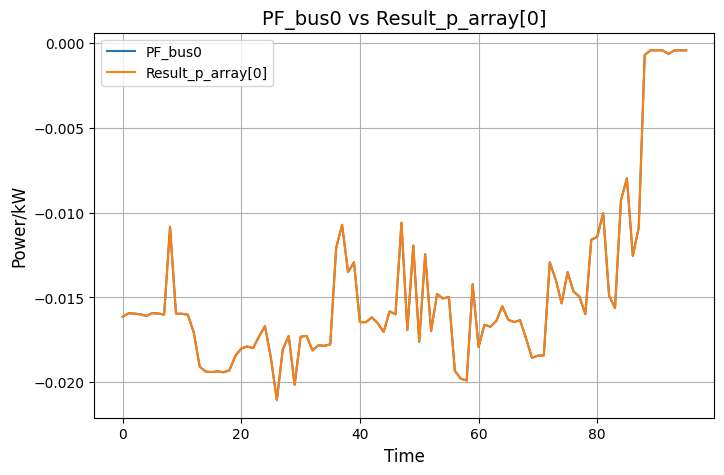

In [12]:
# compare PF_bus0 with Result_p_array[0] in every time step in a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(PF_bus0, label='PF_bus0')
plt.plot(Result_p_array[0], label='Result_p_array[0]')
# add sum (Result_p_array[i] for i in range(1, n_bus)) to the plot
# plt.plot(-sum(Result_p_array[i] for i in range(1, n_bus)), label='Sum of Result_p_array[i]')
#plot the total load power in every time step
# plt.plot(-LoadPower.iloc[:,1:].sum(axis=1).values*1E-3, label='Total Load Power')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power/kW', fontsize=12)
plt.title('PF_bus0 vs Result_p_array[0]', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [136]:
#check the transformer's power 
min_value = min(TransAva)
max_value = max(PFdiff)
# Check if the transformer power of the pf fit the congestion limit
if min_value < 0:    
    locations = [i for i, val in enumerate(TransAva) if val == min_value]
    print(f"Congestion Management Error: {min_value}")
    print(f"Locations of Errors: {locations}")
#calculate the difference between the pf and opf
print(f"The power flow validate the OPF result, the biggest difference is: {max_value}MW")

The power flow validate the OPF result, the biggest difference is: 3.656321740340418e-07MW
